In [ ]:
#Instalação bibliotecas
!pip install geemap
!pip install earth-engine api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement earth-engine (from versions: none)
ERROR: No matching distribution found for earth-engine


In [ ]:
#Importar bibliotecas
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Autenticação
ee.Authenticate()
ee.Initialize(project='usuariogee')

In [ ]:
#Pontos e área de estudo (Buffer)
pontos = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([x, y]), {'nome': 'Ponto Z31'}) #ponto geográfico
])

buffer_size = 30  # metros --> criado para ser a área em torno do ponto --> permitir cálculos de NDVI e máscaras sem erro [antes:  (•)  um ponto | depois: (⬤)  uma pequena área circular]
area_buffer = pontos.map(lambda f: f.buffer(buffer_size)).union() #uma única área (como um só pacote) - garante geometria única --> certas operações podem falhar

In [ ]:
#Criar mapa interativo
Map = geemap.Map()

Map.addLayer(pontos, {'color': 'blue'}, 'Pontos')
Map.addLayer(area_buffer, {'color': 'gray'}, 'Área com Buffer')
Map.centerObject(area_buffer, 13)
Map

Map(center=[-5.781472968977258, -51.8667948389214], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
#Coleção Landsat 8
collection = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterDate('2014-01-01', '2024-07-25')
    .filterBounds(area_buffer)
    .filter(ee.Filter.inList('WRS_PATH', [225]))
    .filter(ee.Filter.inList('WRS_ROW', [64]))
    .sort('system:time_start')
)

In [ ]:
#Máscara de nuvem + buffer
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_bit = 1 << 3
    shadow_bit = 1 << 4
    cirrus_bit = 1 << 2

    cloud_mask = (
        qa.bitwiseAnd(cloud_bit).eq(0)
        .And(qa.bitwiseAnd(shadow_bit).eq(0))
        .And(qa.bitwiseAnd(cirrus_bit).eq(0))
    )

    aerosol = image.select('SR_QA_AEROSOL').bitwiseAnd(192).rightShift(6)
    aerosol_mask = aerosol.lte(1)

    combined_mask = cloud_mask.And(aerosol_mask)

    buffered_mask = combined_mask.focal_min(
        radius=100,
        units='meters',
        kernel=ee.Kernel.circle(100, 'meters'),
        iterations=1,
    )

    return image.updateMask(buffered_mask)


masked_collection = collection.map(mask_clouds)


In [ ]:
#Preenchimento pixel a pixel
def fill_clouds_per_pixel(image):
    current_time = image.get('system:time_start')
    next_images = masked_collection.filter(ee.Filter.gt('system:time_start', current_time))
    mask = image.mask().Not()

    def iterate_func(next_img, prev_filled):
        next_img = ee.Image(next_img)
        return ee.Image(prev_filled).unmask(next_img.updateMask(mask))

    filled = ee.Image(next_images.iterate(iterate_func, image))
    return filled.copyProperties(image, image.propertyNames())


filled_collection = masked_collection.map(fill_clouds_per_pixel)

In [ ]:
#Escala e NDVI
#Digital Number - DN --> Surface Reflectance - SR
def scale_and_add_ndvi(image): #recebe uma imagem do GEE como entrada
    time_start = image.get('system:time_start') #pega o valor da propriedade 'system:time_start' da imagem --> indica a data e hora da imagem
    optical = (
        image.select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']) #seleciona as bandas de reflectância de superfície do Landsat 8
        .multiply(0.0000275) #converte os valores inteiros fornecidos pelo Landsat em reflectância real
        .add(-0.2) #ajusta a reflectância
        .rename(['B2','B3','B4','B5','B6','B7']) #renomeia as bandas para nomes mais simples
    )

    ndvi = optical.normalizedDifference(['B5','B4']).rename('NDVI') #calcula o NDVI + renomeia a banda resultante como NDVI

    return (
        image.addBands(optical) #adiciona essas bandas corrigidas à imagem original
        .addBands(ndvi) #adiciona a banda NDVI à imagem original
        .set('date', ee.Date(time_start).format('YYYY-MM-dd')) #cria 'date' dentro da imagem
    )


processed = filled_collection.map(scale_and_add_ndvi) #cada imagem da coleção agora tem as bandas calibradas + NDVI + data legível

In [ ]:
#Recorte final ao buffer
processed_clipped = processed.map(lambda img: img.clip(area_buffer)) #nova coleção de imagens, igual a processed, mas cada imagem recortada apenas para a área do buffer

In [ ]:
#Extração do valor do pixel central
def extract_center_pixel(image): #image como entrada --> extrair os valores das bandas e NDVI no ponto central do buffer
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd') #formato
    pixel_point = pontos.first().geometry().centroid(1)  #ponto exato onde vamos amostrar os valores das bandas

    result = image.reduceRegion(  #extrai valores de uma região da imagem
        reducer=ee.Reducer.first(), #pega o valor do primeiro pixel encontrado (como só temos um ponto, pega exatamente ele)
        geometry=pixel_point, #região de amostragem (nosso ponto central)
        scale=30, #padrão Landsat
        maxPixels=1e9,
        tileScale=1,
    )

    return ee.Feature(None, { #cria uma Feature com as propriedades:
        'date': date,
        'NDVI': result.get('NDVI'),
        'B2': result.get('B2'),
        'B3': result.get('B3'),
        'B4': result.get('B4'),
        'B5': result.get('B5'),
        'B6': result.get('B6'),
        'B7': result.get('B7'),
    })


pixel_values = processed_clipped.map(extract_center_pixel)

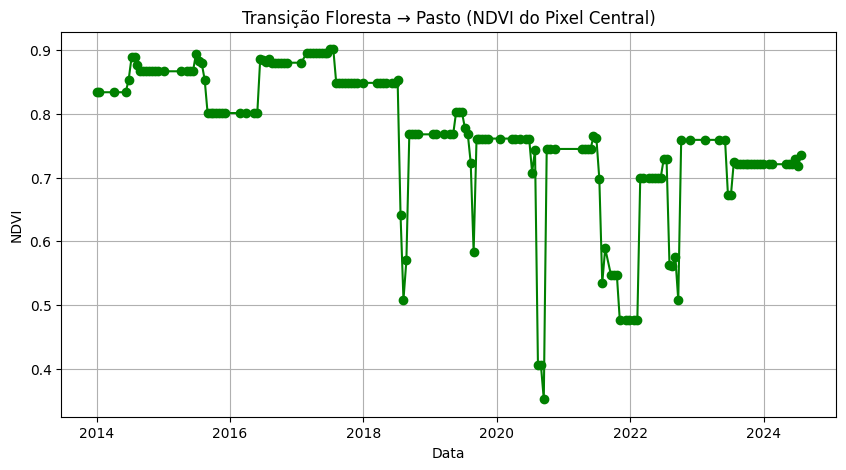

In [ ]:
#Filtrar imagens válidas
filtered_pixel_values = pixel_values.filter(ee.Filter.notNull(['NDVI'])) #mantém apenas as Features que têm NDVI válido

#Visualização e exportação
#Gráfico NDVI
data = filtered_pixel_values.getInfo()['features'] #pega a lista de Features (cada Feature é um pixel central de uma imagem)
rows = [{'date': f['properties']['date'], 'NDVI': f['properties']['NDVI']} for f in data]

df = pd.DataFrame(rows)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

plt.figure(figsize=(10,5))
plt.plot(df['date'], df['NDVI'], color='green', marker='o')
plt.title('Transição Floresta → Pasto (NDVI do Pixel Central)')
plt.xlabel('Data')
plt.ylabel('NDVI')
plt.grid(True)
plt.show()


In [ ]:
task = ee.batch.Export.table.toDrive(
    collection=filtered_pixel_values,   # FeatureCollection que você quer exportar
    description='Export_pixel_NDVI',    # nome da tarefa no GEE
    fileFormat='CSV',                    # formato do arquivo
    fileNamePrefix='NDVI_PixelCentral_Ponto1'  # prefixo do arquivo
)
task.start()  # inicia a exportação